# LP2 Classification Problem

### 1. Business Understanding
#### 1.1 Description 

In today's rapidly evolving telecommunications industry, service providers face intense competition, making the retention of existing customers a critical challenge. It is well-known that the cost of acquiring new customers outweighs that of retaining existing ones. To address this challenge, our project aims to develop a churn prediction model to forecast customer attrition and facilitate targeted retention strategies. 

#### 1.2 Objective  
The primary objective of this project is to create an efficient churn prediction model that can identify customers at risk of churning. By proactively identifying potential churners, the telecom company can take timely and personalized actions to retain valuable customers and prevent revenue loss.  

#### 1.3 Approach 
Our approach involves implementing machine learning techniques for churn prediction. We will explore and compare the performance of two popular algorithms: Logistic Regression, Decision Trees, Random Forest, and Support Vector Machines (SVM). 

  
### 2. Data understanding
There are 3 datasets used in this project. They all contain information about customers in a Telecom company. The following describes the columns present in the data.

* **Gender** -- Whether the customer is a male or a female

* **Partner** -- Whether the customer has a partner or not (Yes, No)

* **SeniorCitizen** -- Whether a customer is a senior citizen or not

* **Dependents** -- Whether the customer has dependents or not (Yes, No)

* **Tenure** -- Number of months the customer has stayed with the company

* **Phone Service** -- Whether the customer has a phone service or not (Yes, No)

* **InternetService** -- Customer's internet service provider (DSL, Fiber Optic, No)

* **MultipleLines** -- Whether the customer has multiple lines or not

* **OnlineSecurity** -- Whether the customer has online security or not (Yes, No, No Internet)

* **OnlineBackup** -- Whether the customer has online backup or not (Yes, No, No Internet)

* **DeviceProtection** -- Whether the customer has device protection or not (Yes, No, No internet service)

* **TechSupport** -- Whether the customer has tech support or not (Yes, No, No internet)

* **StreamingTV** -- Whether the customer has streaming TV or not (Yes, No, No internet service)

* **StreamingMovies** -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

* **Contract** -- The contract term of the customer (Month-to-Month, One year, Two year)

* **PaperlessBilling** -- Whether the customer has paperless billing or not (Yes, No)

* **Payment Method** -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

* **MonthlyCharges** -- The amount charged to the customer monthly

* **TotalCharges** -- The total amount charged to the customer

* **Churn** -- Whether the customer churned or not (Yes or No)


<br>

#### **Installing and importing libraries**


In [263]:
%pip install pyodbc  
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [264]:
#pip install scikit-learn==1.2.2

In [265]:
import pyodbc
from dotenv import dotenv_values 

# Analysis libraries
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
import re
import datetime
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor


#Machine learning libraries
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score, recall_score, precision_score, f1_score,roc_auc_score,roc_curve
from sklearn.feature_selection import RFE, RFECV
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler



# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from prettytable import PrettyTable
# Warning libraries
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

#### **Loading data**

In [266]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [267]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [268]:
# Now the sql query to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query = "Select * from dbo.LP2_Telco_churn_first_3000"
df1 = pd.read_sql(query, connection)
df1.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [269]:
df2=pd.read_csv("data/LP2_Telco-churn-last-2000.csv.")
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [270]:
#Checking if columns are same before concatination
print(f'dataset_1: {df1.columns}\n\n\
        dataset_2: {df2.columns}')

dataset_1: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

        dataset_2: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [271]:
# Concatenate the DataFrames to get one data set for the work
data=pd.concat([df1,df2])
data.sample(20)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2619,3336-JORSO,Female,True,False,False,33,True,True,Fiber optic,False,...,True,True,True,True,Month-to-month,True,Electronic check,110.449997,3655.449951,True
1482,9290-SHCMB,Female,True,False,False,13,True,False,Fiber optic,False,...,True,False,True,True,Month-to-month,True,Electronic check,96.849998,1235.550049,False
2989,3308-MHOOC,Male,False,False,True,1,True,False,No,None,...,None,None,None,None,Month-to-month,True,Mailed check,19.200001,19.200001,False
776,9505-SQFSW,Female,False,True,True,3,False,None,DSL,False,...,False,False,False,True,Month-to-month,False,Mailed check,40.299999,92.5,False
672,3276-HDUEG,Female,False,False,False,1,True,True,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Mailed check,75.050003,75.050003,True
245,5902-WBLSE,Female,0,Yes,Yes,70,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),20.150000,1411.2,No
244,4522-AKYLR,Female,True,False,False,13,True,False,DSL,False,...,True,False,False,False,Month-to-month,True,Electronic check,54.799999,731.299988,False
1367,4238-HFHSN,Male,True,True,False,61,True,True,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,82.150002,4904.850098,False
2553,9137-NOQKA,Male,True,False,False,2,True,False,No,None,...,None,None,None,None,Month-to-month,False,Electronic check,19.200001,37.200001,False
587,1707-HABPF,Female,1,No,No,46,Yes,No,Fiber optic,No,...,Yes,No,Yes,No,One year,Yes,Bank transfer (automatic),91.300000,4126.35,No


#### **Previewing the dataset**

In [272]:
#Preview the data
print(data.shape,"\n")
print(data.info())

(5043, 21) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-nu

**From the summary above:**
* All columns are string except for ```SeniorCitizen``` ,```tenure ``` and  ```MonthlyCharges```
* There are missing values in several columns.

**From thoroughly examining the dataset, we came out with the following analytical questions:**

* What is the correlation between phone service and churn?
* Do charges contribute to customer churn?
* What is the average tenure of customers?
* How is customer churn aligned with whether a customer has a partner and dependents or not?
* Does being a senor citizen contribute significantly to churn?
* Is customer retention heavily dependent on customer's access to tech support?
* What effect does the online security have on tenure?
* What factors/variables significantly contribute to customer churn?

**Hypothesis Testing**

Hypothesis 1<br>
_**Null:**_ Total charges do not contribute to churn rate among customers.<br>
_**Alternate:**_ Total charges significantly contribute to churn rate among customers.

Hypothesis 2 <br>
_**Null:**_ Customer churn rate does not depend on multiple services subscription.<br>
_**Alternate:**_ Customer churn rate significantly depend on multiple services subscription.




In [273]:
#Getting unique values for each column
for col in data.columns:
    print(f"Unique values of {col} are {data[col].unique()}\n")

Unique values of customerID are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique values of gender are ['Female' 'Male']

Unique values of SeniorCitizen are [False True]

Unique values of Partner are [True False 'No' 'Yes']

Unique values of Dependents are [False True 'No' 'Yes']

Unique values of tenure are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique values of PhoneService are [False True 'Yes' 'No']

Unique values of MultipleLines are [None False True 'No' 'No phone service' 'Yes']

Unique values of InternetService are ['DSL' 'Fiber optic' 'No']

Unique values of OnlineSecurity are [False True None 'No' 'Yes' 'No internet service']

Unique values of OnlineBackup are [True False None 'No' 'Yes' 'No internet service']

Unique values of DeviceProtection are [F

**Issues arising :**
* Most columns have two values which mean the same thing eg. In ```Partner``` there are values like 'False' and 'No' which mean the same thing.
*  For columns ```MonthlyCharges``` and ```TotalCharges``` , the values should be in a standard decimal place
*  The ```TotalCharges``` column should be converted to float datatype.

### 3. Data preparation

#### 3.1 Data cleaning

**Dealing with duplicates**

In [274]:
data.duplicated().value_counts()

False    5043
dtype: int64

The data contains no duplicates.<br> 

**Data uniformity**

* The ```TotalCharges``` and ```MonthlyCharges``` columns have different decimal places so we are going to standardize the columns to 2 dp. 
* But first of all, the ```TotalCharges``` column needs to be converted to a numeric data type as it is in string format.




In [275]:
#Converting to numric data type
data["TotalCharges"]=pd.to_numeric(data["TotalCharges"],errors="coerce")
data["TotalCharges"].dtype

dtype('float64')

In [276]:
#Formatting to 2 decimal places
data["MonthlyCharges"]= data["MonthlyCharges"].round(2)
data["TotalCharges"] = data["TotalCharges"].round(2)
data[["MonthlyCharges","TotalCharges"]].sample(4)


,MonthlyCharges,TotalCharges
833,88.80,3340.55
2267,113.65,8124.20
1027,94.90,4615.25
2980,25.45,1866.45


**Cleaning the categorical columns**

In [277]:
# Function to convert 'Yes'/'No' values to booleans


def convert_to_boolean(df, column):

    def convert_value(value): 

        if value == True:
            return "Yes"

        elif value == False:
            return "No"

        else:
            return value

    df[column] = df[column].apply(convert_value)

    return df



In [278]:

# Create a list of categorical variables by excluding numerical columns
cat_variables = data.drop(['customerID','tenure','TotalCharges','MonthlyCharges'], axis=1)
cat_variables

# Invoke function to convet for all columns in data
for col in cat_variables:
    data = convert_to_boolean(data, col)

In [279]:
# Validate

#Getting unique values for each column
for col in data.columns:
    print(f"Unique values of {col} are {data[col].unique()}\n")

Unique values of customerID are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique values of gender are ['Female' 'Male']

Unique values of SeniorCitizen are ['No' 'Yes']

Unique values of Partner are ['Yes' 'No']

Unique values of Dependents are ['No' 'Yes']

Unique values of tenure are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique values of PhoneService are ['No' 'Yes']

Unique values of MultipleLines are [None 'No' 'Yes' 'No phone service']

Unique values of InternetService are ['DSL' 'Fiber optic' 'No']

Unique values of OnlineSecurity are ['No' 'Yes' None 'No internet service']

Unique values of OnlineBackup are ['Yes' 'No' None 'No internet service']

Unique values of DeviceProtection are ['No' 'Yes' None 'No internet service']

Unique values of TechSuppor

**Cleaning the tenure column**
- It was noticed that there are values with 0 from the ```Tenure ``` column, upon closer inspection the same rows have ```Churn``` as False and ```Totalcharges``` were missing since totalcharges is a product of tenure and monthlycharges. However, its rather odd that if the customers did not stay with the company for more than a month , they should have churned but that is not the case therefore, we will delete these rows.

In [280]:
# Inspecting the `tenure` column
data[data["tenure"] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,None,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,None,...,None,None,None,None,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,None,...,None,None,None,None,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,None,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
1670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
1754,2775-SEFEE,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


In [281]:
#Dropping the rows
data.drop(labels=data[data["tenure"] == 0].index,axis= 0,inplace= True)

In [282]:
#Confirming
data[data["tenure"] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


**Handling missing values**

In [283]:
#Checking missing values
data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       267
InternetService       0
OnlineSecurity      649
OnlineBackup        649
DeviceProtection    649
TechSupport         649
StreamingTV         649
StreamingMovies     649
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 1
dtype: int64


**Decison mades:**

* Given that ```OnlineSecurity```, ```OnlineBackup``` ,```DeviceProtection```  ,```TechSupport```, ```StreamingTV```,```StreamingMovies``` and ```Mutliple lines``` are categorical columns, instead of dropping the columns or imputing with the mode , we are going to replace them with False. This is because in the real world , if someone doesn't fill an entry for a 'No' or 'Yes' question chances are very high they don't have the particular thing. This is an assumption but one that makes sense.<br>

* For the missing ```Churn``` value ,it will be dropped.

In [284]:

# fill the null categorical values with 'False'
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')
data['TechSupport'] = data['TechSupport'].fillna('No')
data['StreamingTV'] = data['StreamingTV'].fillna('No')
data['StreamingMovies'] = data['StreamingMovies'].fillna('No')
data['MultipleLines'] = data['MultipleLines'].fillna('No')


#Dropping the missing value row 
data=data.dropna(axis=0,subset=["Churn"])




In [285]:
#Confirming if missing values are still there
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [286]:
data.columns = data.columns.str.lower() #convert all columns to lower case
data.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [287]:
# Save the bridged data as csv file
data.to_csv('data/complete.csv',index=False)

**Inspecting outliers by Visualization**

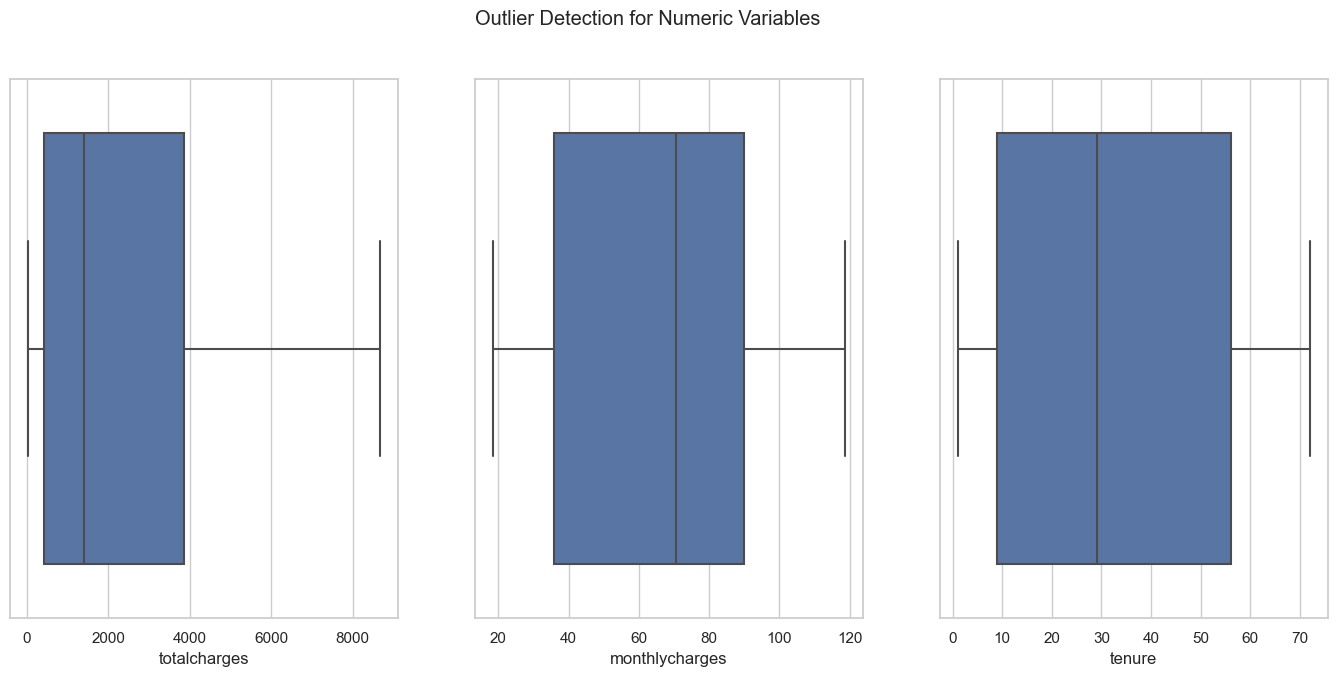

In [288]:
#Plotting box plot to visualize outliers
numerical_col=["monthlycharges","totalcharges", "tenure"]
fig,axes= plt.subplots(ncols=3,nrows=1,figsize=(17,7))

sns.boxplot(x=data['totalcharges'],ax=axes[0])
sns.boxplot(x=data['monthlycharges'],ax=axes[1])
sns.boxplot(x=data['tenure'],ax=axes[2])
title =fig.suptitle('Outlier Detection for Numeric Variables')

plt.show()

**Observations from outlier analysis.**

*  Our numerical columns are within range ,as no outliers can be seen.  

*  However, `TotalCharges` and `MonthlyCharges` are positively and negatively skewed respectively. 
* `TotalCharges` exhibits a tail that extends towards larger values (4000). Its mean, therefore is greater than the median, which is also greater than the mode.<br>
*  On the other hand, `MonthlyCharges` extends its tail towards the smaller values (40). This indicates a lesser mean than the median, which is also less than the mode

*  The `tenure` column has a near normal distribution.

#### 3.2 Exploratory Data Analysis (EDA).

*  EDA is an essential and crucial initial step in the data analysis process, where the main objective is to gain insights and understanding of the dataset before performing any formal statistical modeling or making inferences.<br> 

* A variety of techniques to summarize, visualize, and interpret crucial characteristics and patterns present in the data are implemented in EDA. 

* EDA encompasses three components: `Univariate`, `Bivariate` and `Multivariate` analysis.

##### 3.2.1. Univariate Analysis
*  Here, we critically examin each variable as a separate entity in terms of statistical distributions.


**EDA of Numeric Variables**

In [289]:
numerical_col  # Get the numerical columns

['monthlycharges', 'totalcharges', 'tenure']

In [290]:
data[numerical_col].describe()

,monthlycharges,totalcharges,tenure
count,5026.000000,5026.000000,5026.000000
mean,65.102407,2299.938778,32.613808
std,30.064849,2268.113979,24.510960
min,18.400000,18.800000,1.000000
25%,35.800000,417.662500,9.000000
50%,70.575000,1400.700000,29.000000
75%,90.050000,3857.012500,56.000000
max,118.650000,8670.100000,72.000000


`MonthlyCharges`

*With the assumption that the monetary figures are quoted in usd,* 

* The `mean` monthly charge is `65usd`.
* The `least` monthly charge is `18usd`.
* `Median` monthly charge is `71usd`
* `Highest` amount charged per month is `119usd`.


`TotalCharges`

* The `mean` total charge is `2301usd`.
* The `least` total charge is `19usd`.
* `Median` total charge is `1401usd`
* `Highest` amount charged per month is `8670usd`.


`tenure`

* The `mean` tenure is `33 months`.
* The `least` recoreded `0 months`.
* `Median` is `29 months`
* `Highest` amount per month is `72 months`.

**Frequency Distributions of Numerical Variables**

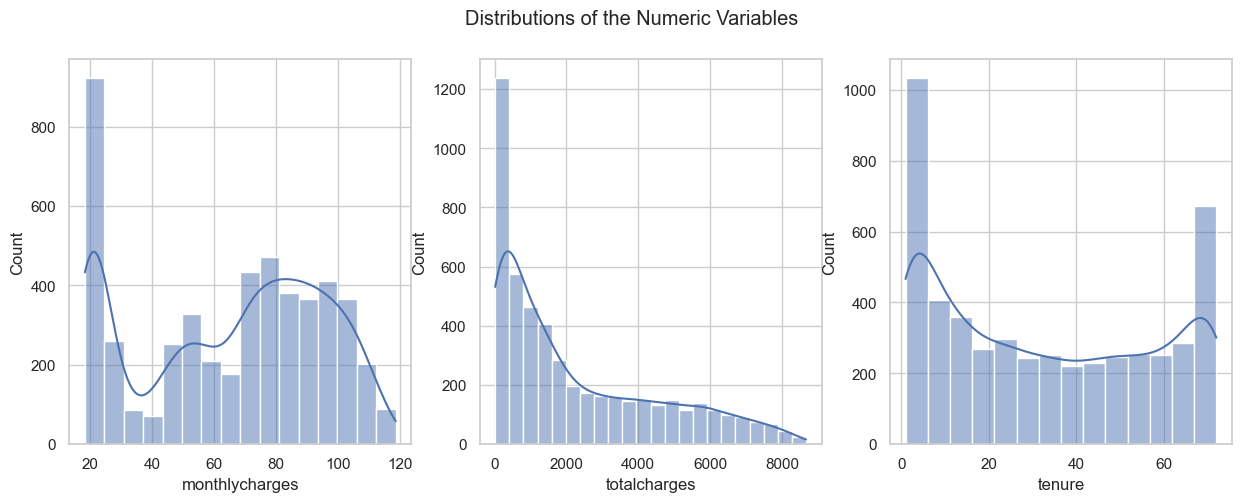

In [291]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Create a figure and three subplots
sns.histplot(data=data['monthlycharges'], kde="Yes", ax=axes[0])  # Plot first figure axes[0]
sns.histplot(data=data['tenure'],kde=True, ax=axes[2])          # Plot third figure axes[2]
sns.histplot(data=data['totalcharges'], kde="Yes", ax=axes[1])    # Plot second figure axes[1]
title = fig.suptitle('Distributions of the Numeric Variables');         # Give general title

**Summary**<br>
`MonthlyCharges`
* The highest(near `1000`) number of customers have very low monthly charges from about `18` usd to `25` usd.
* The middle class was charged between `50` to `100` usd.
* The top users incured above `100` usd.



`TotalCharges`

* Majority of customers have total charges below `2000` usd.
* The middle class was charged between `2000` to `6000` usd in total.
* The top users incured above `6000` usd as their total charges.


`tenure`

* Most customers have tunure of `5` months and less and above `65` months.
* On average, customers' tenure is about `35` months.

**EDA of Categorical Variables**

In [292]:
# Create a list of categorical variables by excluding numerical columns
data = data.drop('customerid', axis=1)
categorical_variables = data.columns[~data.columns.isin(numerical_col)].tolist()
categorical_variables

['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'churn']

Get the statistical summary about the categorical variables

In [293]:
# Get the statistical distribution

data[categorical_variables].describe()

,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,churn
count,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,2548,4209,2579,3476,4539,2684,2244,3150,2877,2865,3116,2665,2623,2740,2985,1698,3692


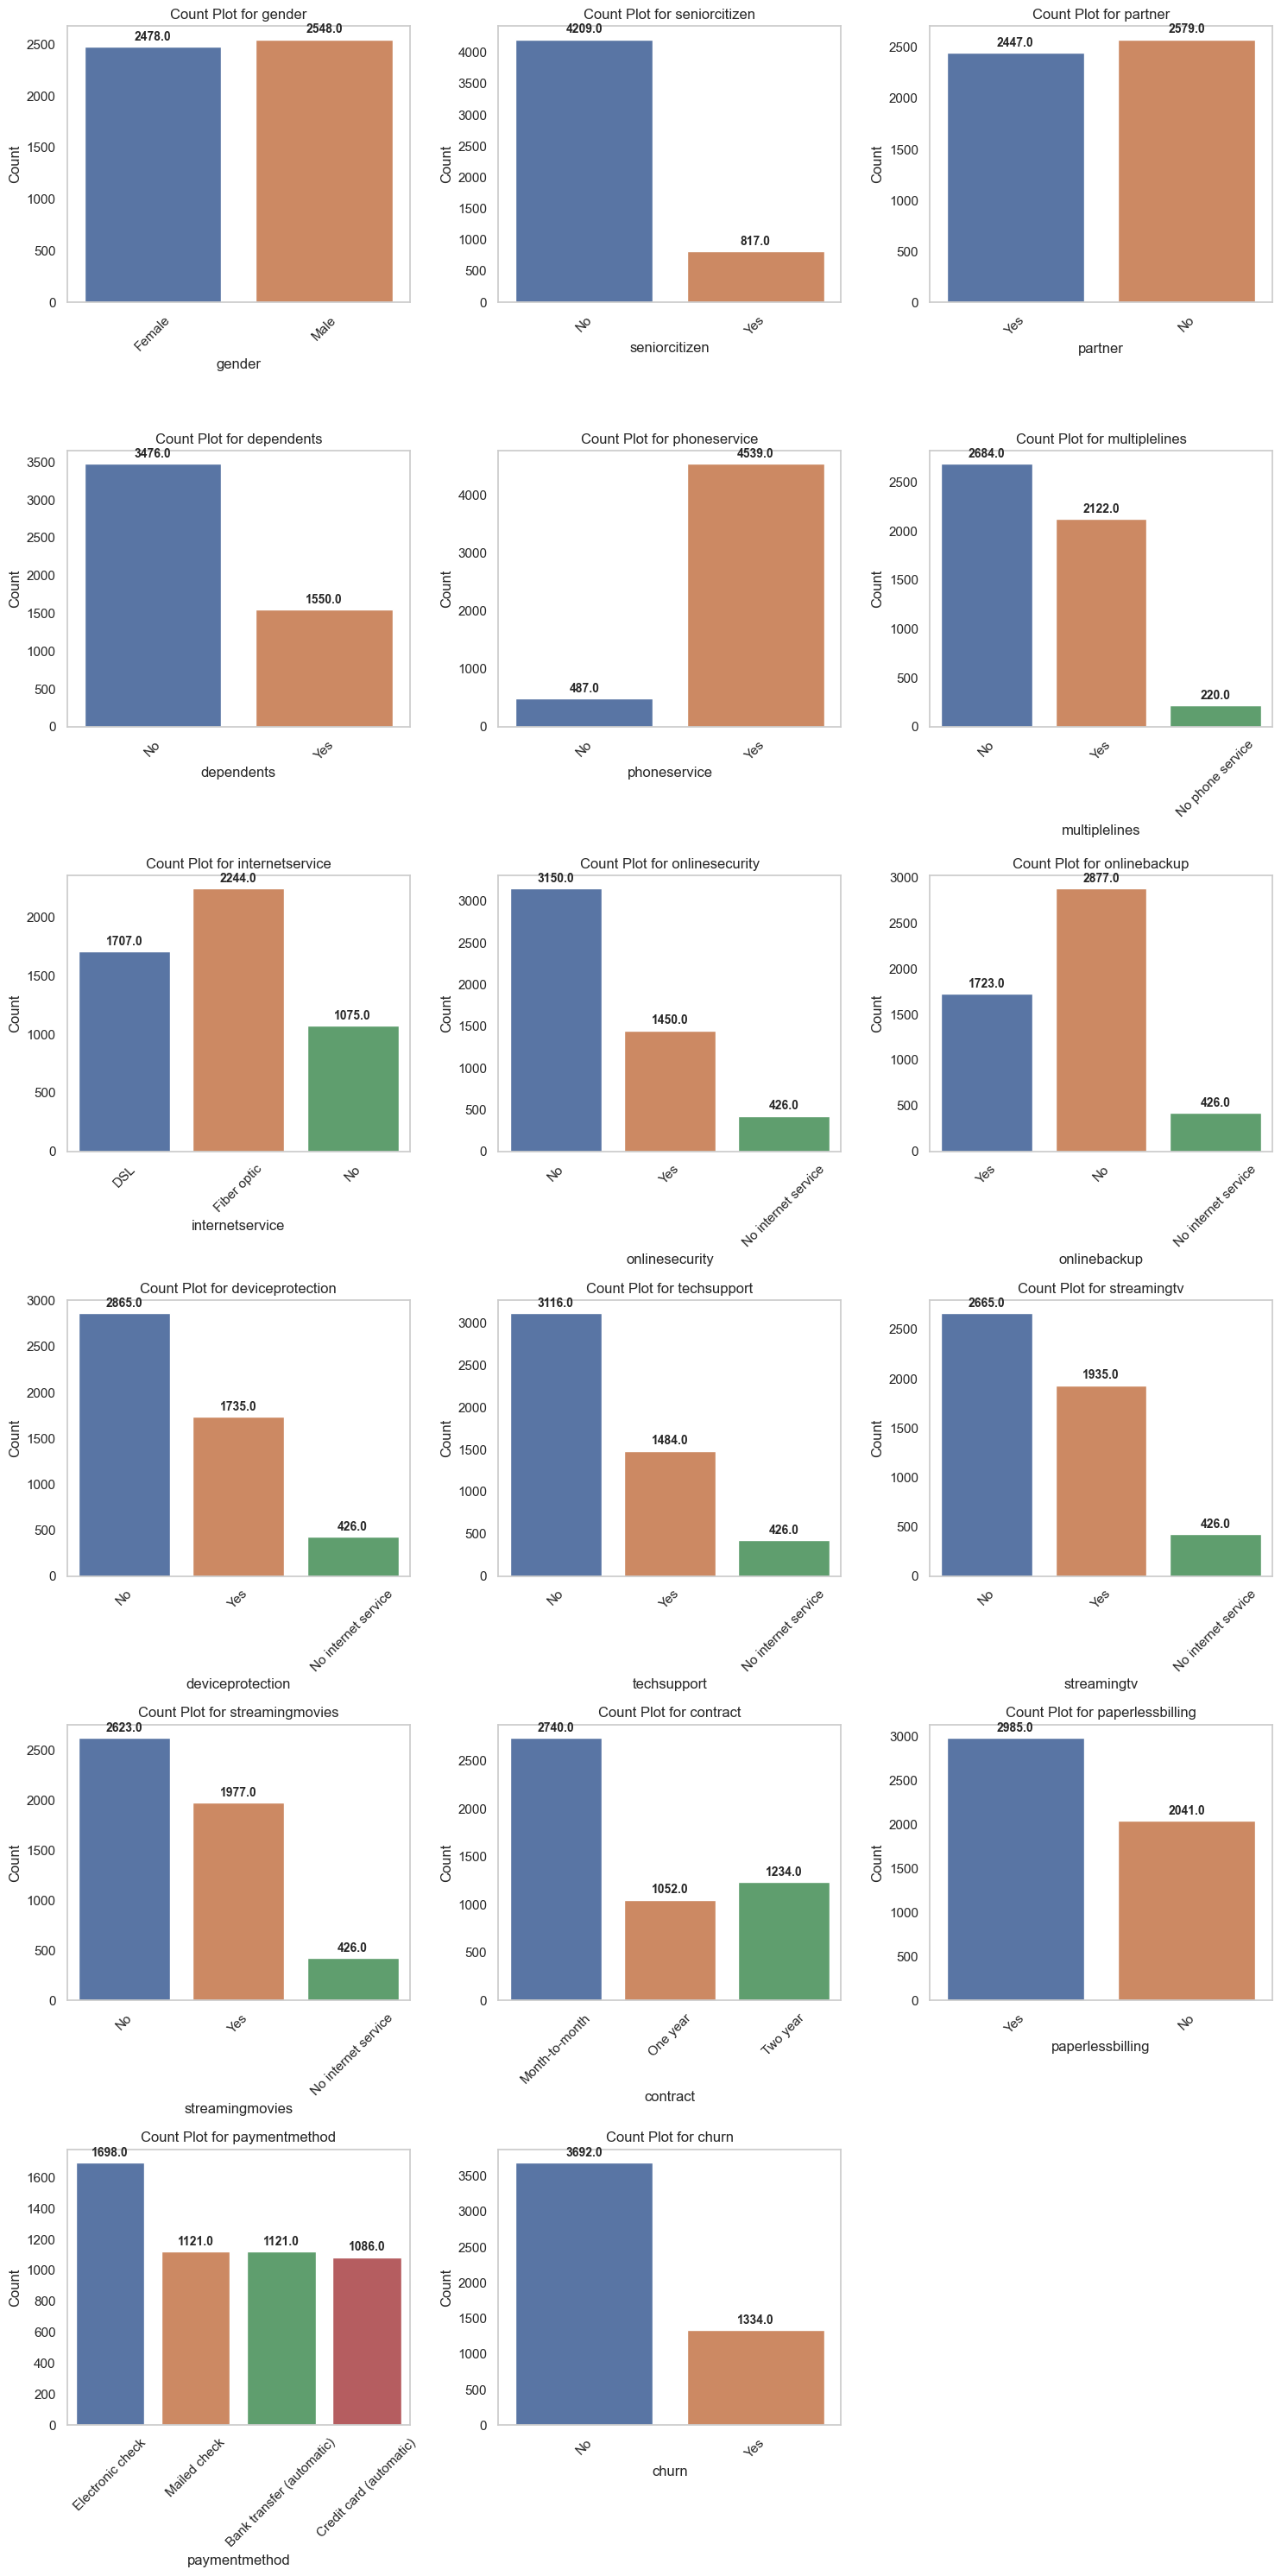

In [294]:
# Calculate the number of rows and columns for subplots
num_cols = 3
num_rows = (len(categorical_variables) - 1) // num_cols + 1

# Plot count plots for all categorical columns
sns.set(style="whitegrid")
plt.figure(figsize=(5 * num_cols, 5 * num_rows))

for i, col in enumerate(categorical_variables):
    plt.subplot(num_rows, num_cols, i + 1)
    ax = sns.countplot(x=col, data=data[categorical_variables])
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Count Plot for {col}")
    plt.xticks(rotation=45)

    # Add count values above each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.grid(False)

plt.tight_layout()  # To improve subplot spacing
plt.show()

**Summary on Observations :**

`Gender`<br>
For this data, gender refers to whether male or female.
There are more males than females. They account for `51% `of customers.

`Seniorcitizen`<br>
Majority of customers are not senior citizens. Out of the 5042 customers, only `819` are 60 or 65 years old and maybe are pensioners.

`Partner`<br>
Customers without partner exceed those with partner with just `128`.

`Dependents`<br>
This variable refers to whether a customer has dependents or not. From the visualization, `3481` customers have no dependents.

`Phoneservice`<br>
For whether or not a customer had subscribed to phone service, `4553`, representing 90% did subscribe.


`Multiplelines`<br>
Among the three unique options to this variable, without multiple lines outweighs the rest. `2693`customers did not have multiple lines.

`Internetservice`<br>
The internet service variable pertains to whether a customer opted for DSL, fiber optic or none. From the statistical summary, `2247`customers subscribed to fiber optic. 

`Onlinesecurity`<br>
More customers (`3158`) did not adopt the online security service.

`Onlinebackup`<BR>
Out of the 5042 customers, `2882` did not subscribe to online backup.

**Examining the Target Variable**

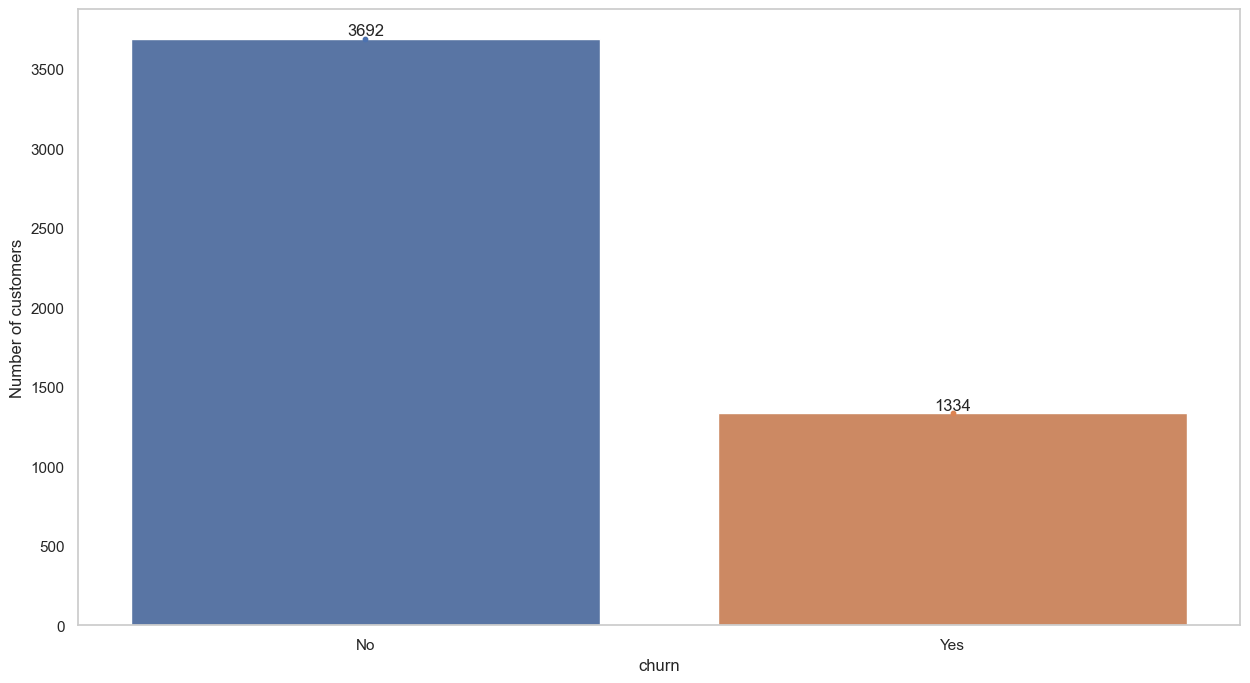

In [295]:
churn_rate=data["churn"].value_counts()
plt.figure(figsize=(15,8))
sns.countplot(x=data["churn"])
plt.ylabel("Number of customers")
for index, value in enumerate(churn_rate):
    plt.scatter(index, value, s=10)  # s=100 for marker size
    plt.annotate(str(value), xy=(index, value), xytext=(index, value+1),
                 ha='center', va='bottom', fontsize=12)

# Remove the grid lines
plt.grid(False)



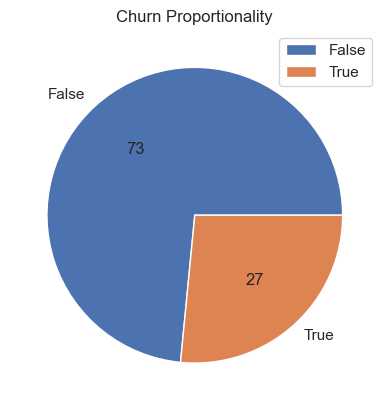

In [296]:
plt.pie(data.churn.value_counts(),
        labels= ['False', 'True'],
        autopct='%.f', normalize=True)
plt.title('Churn Proportionality')
plt.legend()
plt.show()

 **Conclusion on the Churn rate**
* There are 3692 customers that remained in the company which is 73% of the customers while 1334 (27% of the customers)  churned meaning the retention rate is higher than the churn rate.
* There is also a class imbalance in the target variable as there is unequal distribution of classes in the dataset. This issue will later be addressed as the machine learning classifier tends to be more biased towards the majority class, causing bad classification of the minority class

##### 3.2.2 Bivariate analysis

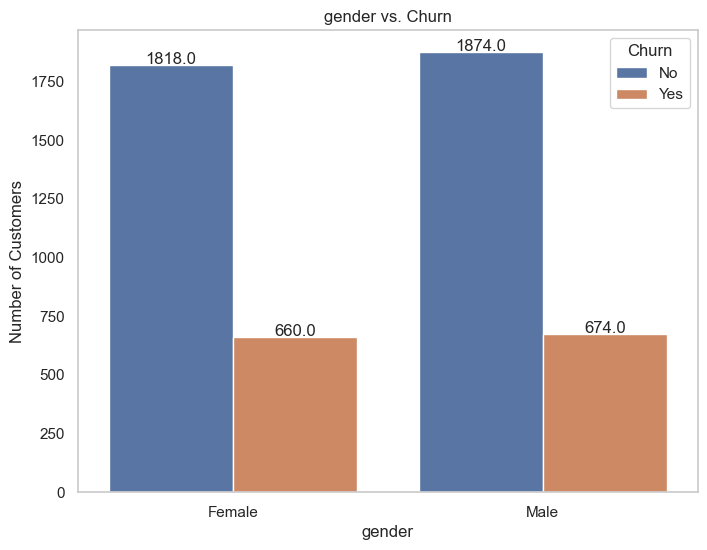

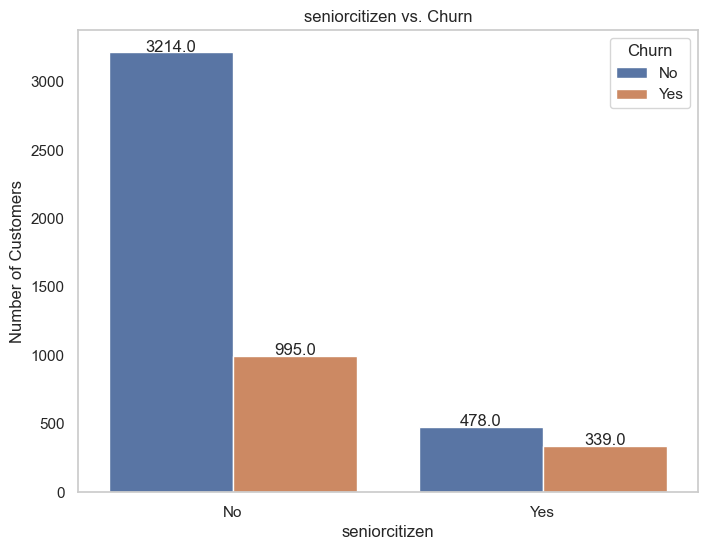

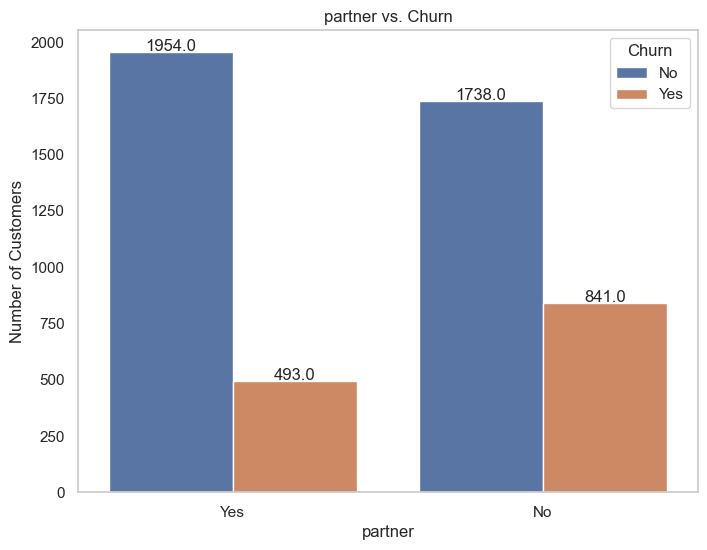

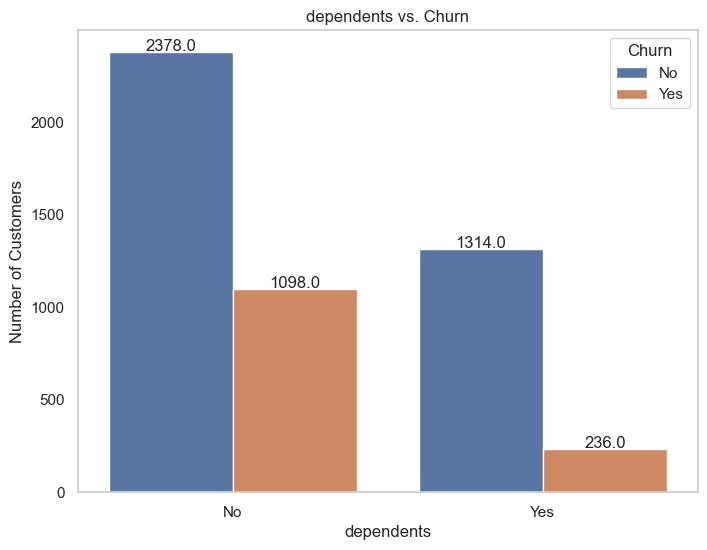

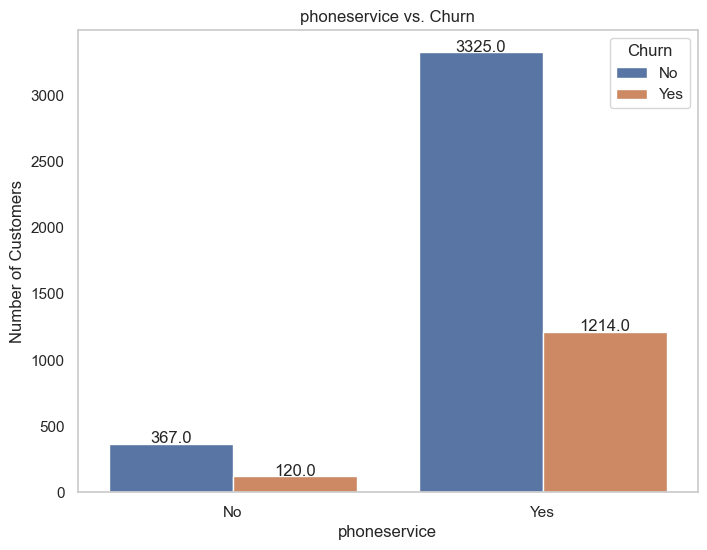

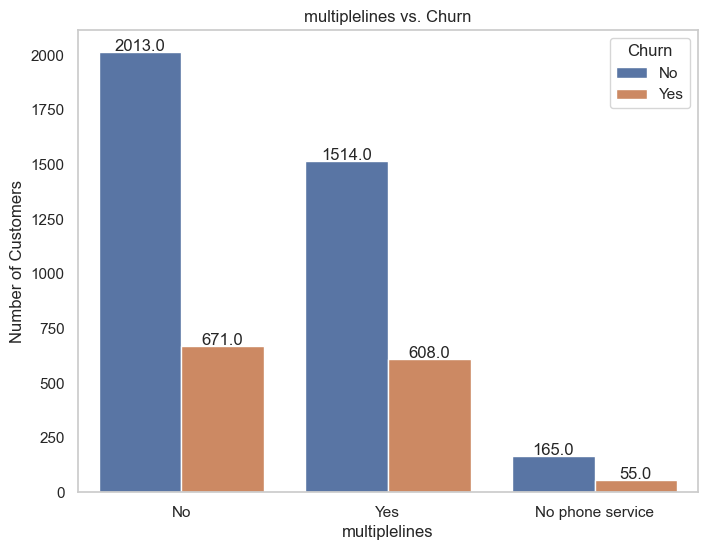

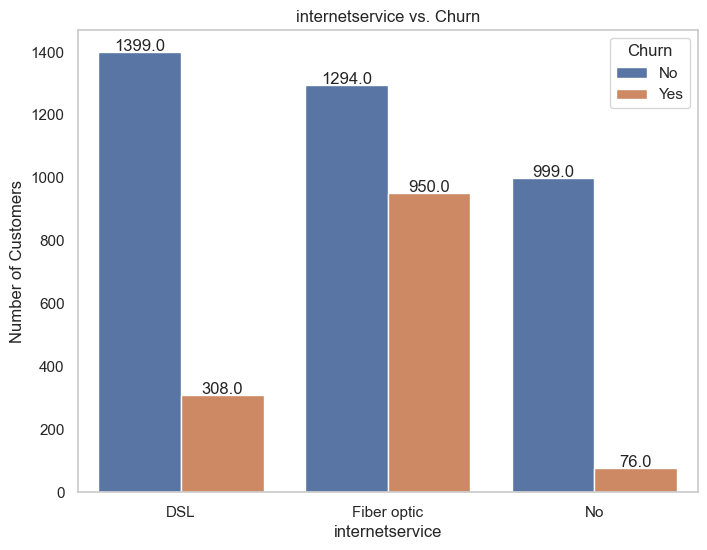

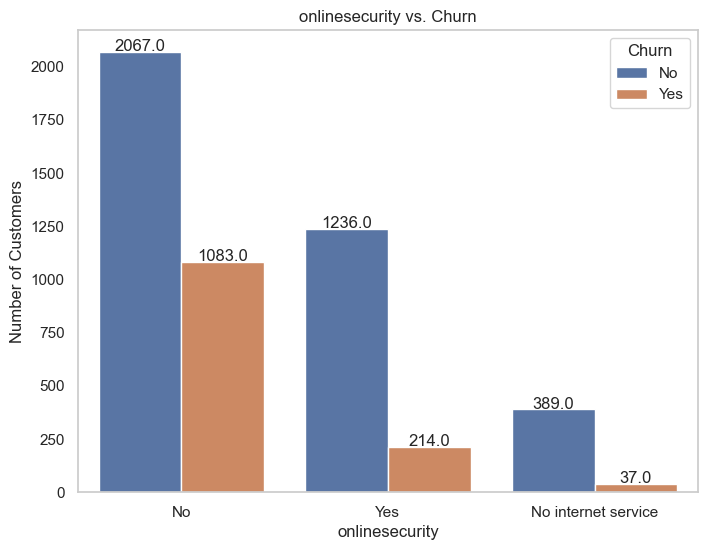

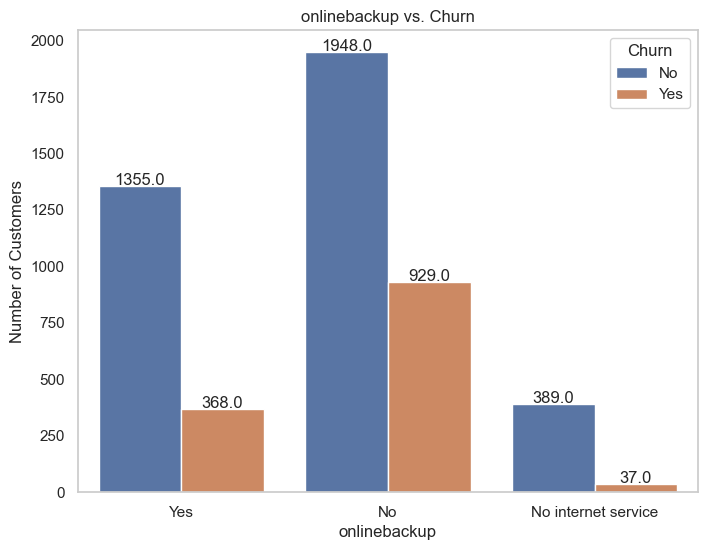

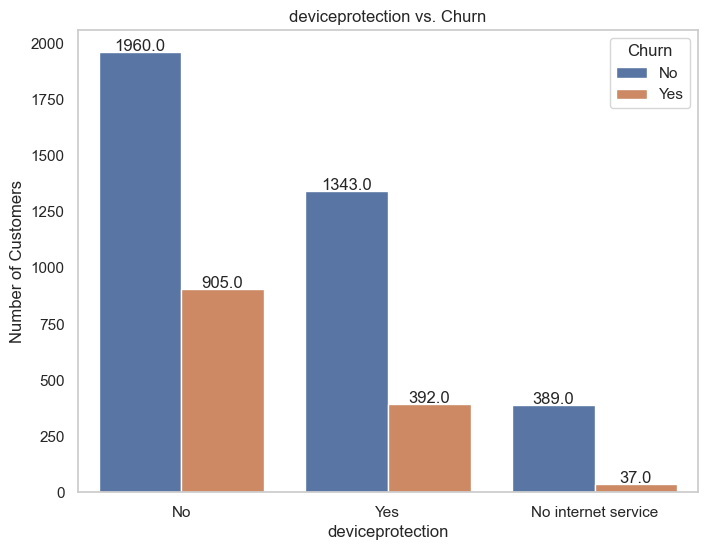

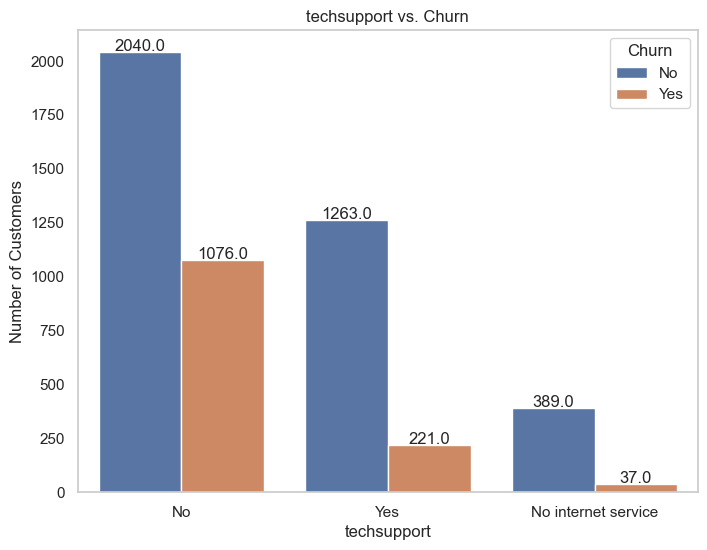

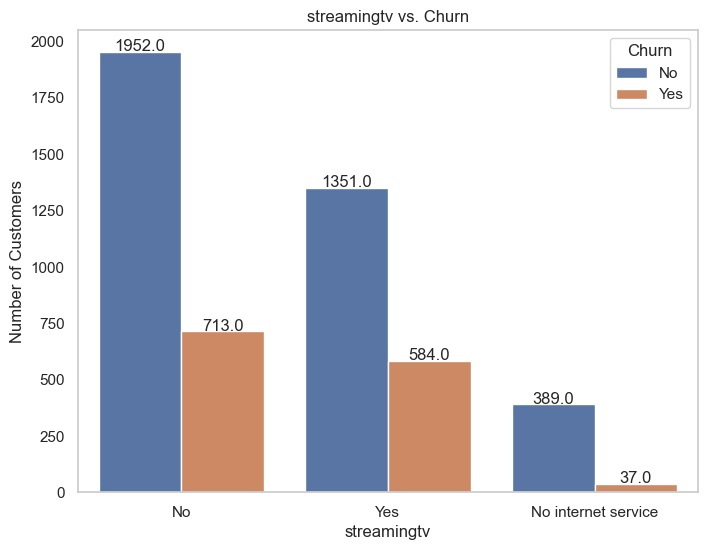

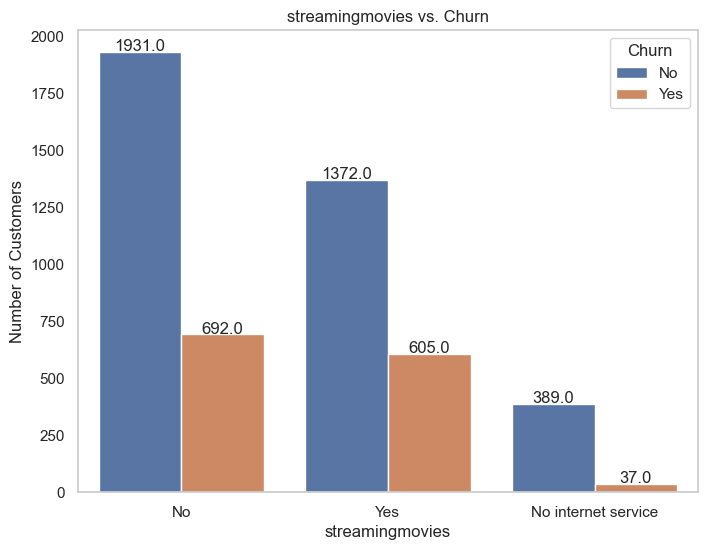

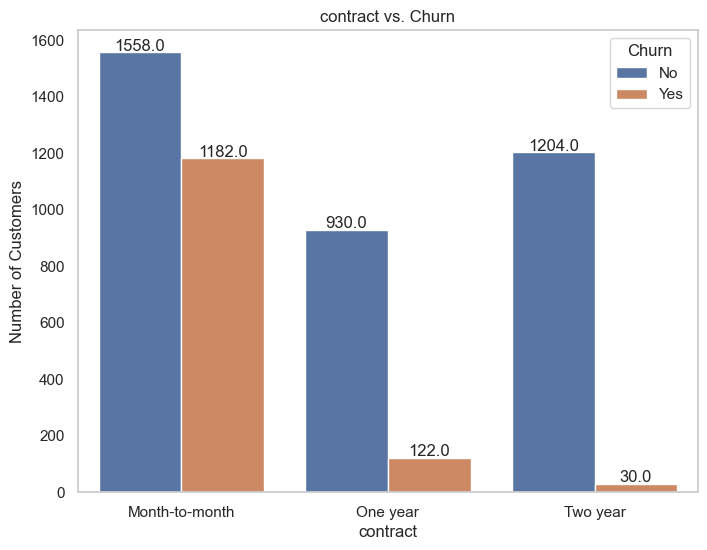

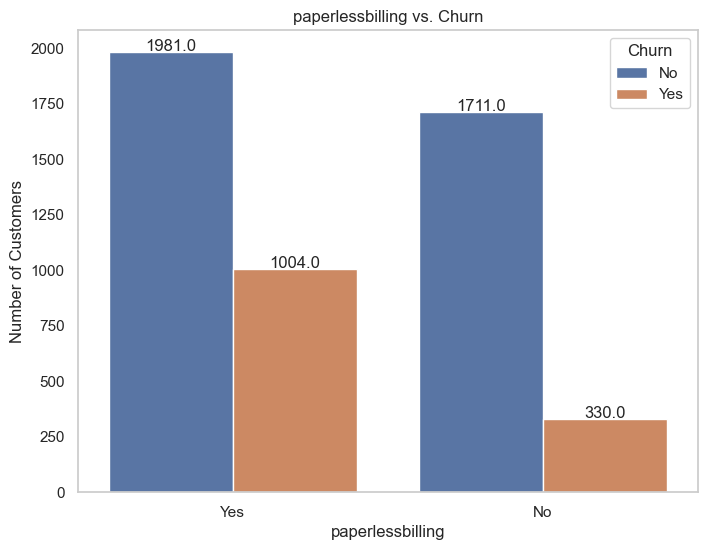

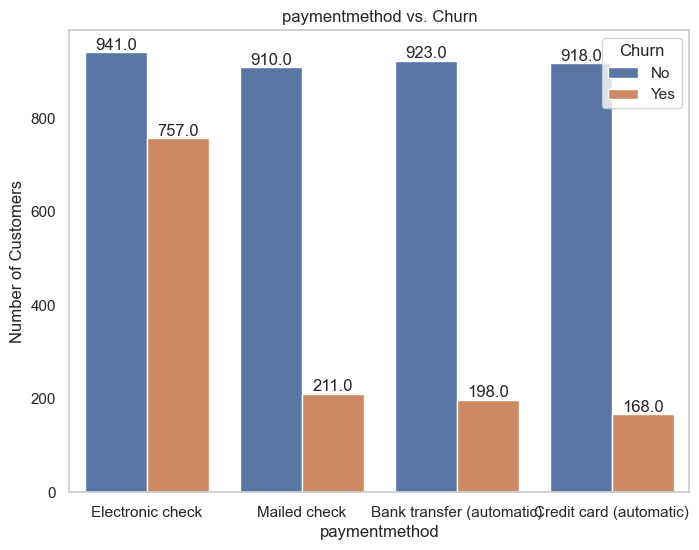

In [297]:


visualization_categorical_variables = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice',
                         'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
                         'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
                         'contract', 'paperlessbilling', 'paymentmethod']
for var in visualization_categorical_variables:
    plt.figure(figsize=(8, 6))
    ax=sns.countplot(x=var, hue='churn', data=data)
    plt.xlabel(var)
    plt.ylabel('Number of Customers')
    plt.title(f'{var} vs. Churn')
    plt.legend(title='Churn', loc='upper right')

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}', ha='center')

    plt.grid(False)
    plt.show()

 


**Summary of Visualizations**

* Males are likely to leave the company more than females. The males are also likely to stay in the company more than females.

*  More senior citizens are likely to stay in a company than quit.

*  Those with partners are more likely to stay in a company as opposed to those without partners who are more likely to quit a company.

*  Those without dependents are more likely to quit the company unlike those with dependents.

* Phone service affects greatly if a customer will churn or not.

* Customers that use multiple lines are likely to stay in a company as opposed to others.

* Most customers that stayed in the company are those that used DSL internet service.
* Most customers that don't use online security are likely to stay in the company.
* Usage of online backup doesn't make a customer stay since most customers that stayed did not utilize the online backup services.
* Technical support can make a customer stay or leave since those that didn't use technical support were the highest contributor to a customer leaving or staying.
* A contract period contributes to churn rate. The shorter the contract term, the higher the rate of churn.
* Paperless billing is a major contributor to a customer not churning. Those that use paperless billing are more likely to stay.
* Most customers that left are those that used electronic check as the method of paying.


### 3.3. Data preprocessing.

Data preprocessing is an integral step in Machine Learning as the quality of data and the useful information that can be derived from it directly affects the ability of our model to learn; therefore, it is extremely important that we preprocess our data before feeding it into our model.It shall involve te following steps:

1. Splitting data into train and test
2. One-hot encoding categorical data
3. Dealing with multicollinearity
4. Dealing with class imbalance in the target variable
5. Dimensionality reduction
6. Scaling the data

In [298]:
data.sample(4)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
914,Male,No,Yes,Yes,72,Yes,Yes,No,No,No,No,No,No,No,Two year,Yes,Bank transfer (automatic),25.20,1798.90,No
1817,Male,Yes,Yes,No,72,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,No,Bank transfer (automatic),98.35,6929.40,No
1105,Female,No,No,No,52,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,One year,Yes,Credit card (automatic),111.25,5916.45,Yes
511,Male,No,No,No,61,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,106.45,6300.15,No


In [299]:
# partion features and target 
X=data.drop("churn",axis=1)
y= data["churn"]

# train test split
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2, random_state =42)

### Churn analysis - The target variable

In [300]:
y.value_counts()

No     3692
Yes    1334
Name: churn, dtype: int64

### From the anlaysis of churn above we can see that there is data imbalance

In [301]:
#Previewing the shape of dataset
print(f"The shape for X_train is {X_train.shape}")
print(f"The shape for X_test is {X_test.shape}")
print(f"The shape for y_train is {y_train.shape}")
print(f"The shape for y_test is {y_test.shape}")

The shape for X_train is (4020, 19)
The shape for X_test is (1006, 19)
The shape for y_train is (4020,)
The shape for y_test is (1006,)


In [302]:
for category in categorical_variables:
    print(f"The unique values for {category} are {data[category].unique()}\n")

The unique values for gender are ['Female' 'Male']

The unique values for seniorcitizen are ['No' 'Yes']

The unique values for partner are ['Yes' 'No']

The unique values for dependents are ['No' 'Yes']

The unique values for phoneservice are ['No' 'Yes']

The unique values for multiplelines are ['No' 'Yes' 'No phone service']

The unique values for internetservice are ['DSL' 'Fiber optic' 'No']

The unique values for onlinesecurity are ['No' 'Yes' 'No internet service']

The unique values for onlinebackup are ['Yes' 'No' 'No internet service']

The unique values for deviceprotection are ['No' 'Yes' 'No internet service']

The unique values for techsupport are ['No' 'Yes' 'No internet service']

The unique values for streamingtv are ['No' 'Yes' 'No internet service']

The unique values for streamingmovies are ['No' 'Yes' 'No internet service']

The unique values for contract are ['Month-to-month' 'One year' 'Two year']

The unique values for paperlessbilling are ['Yes' 'No']

The uniq

In [303]:
train_catergorical_column= ['gender', 'seniorcitizen', 'partner', 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'churn']

In [304]:
categorical_variables


['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'churn']

### Binary Encoding for columns with two values

In [305]:
#Binary encoding
binary_columns=['seniorcitizen', 'partner', 'dependents','phoneservice']
for col in binary_columns:
    X_train[col]=X_train[col].apply(lambda x: 1 if x in ['Yes'] else 0)
X_train.sample(5)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
1337,Male,0,0,0,31,1,No,No,No,No,No,No,No,No,Two year,No,Bank transfer (automatic),20.40,609.10
1663,Male,0,1,0,51,1,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.65,4812.75
88,Female,0,1,1,57,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.75,1272.05
1658,Male,1,0,0,27,1,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,81.45,2122.05
280,Female,0,1,1,33,1,Yes,DSL,No,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,79.15,2531.40


### One hot encoding for more than two values of categorical variable

In [306]:
non_binary_columns=['multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod']

In [307]:
#One hot encode categorical data
for col in non_binary_columns:
    dummies=pd.get_dummies(X_train[col],prefix=col,drop_first=True)
    X_train=X_train.drop(col,axis=1)
    X_train=pd.concat([X_train,dummies],axis=1)
X_train.head(5)


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,monthlycharges,totalcharges,multiplelines_No phone service,multiplelines_Yes,...,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
989,Male,1,1,0,3,1,94.60,279.55,0,1,...,0,1,0,1,0,0,1,0,1,0
150,Female,0,1,1,8,1,68.55,564.35,0,0,...,0,1,0,1,0,0,1,0,1,0
1457,Male,0,1,0,42,1,108.30,4586.15,0,1,...,0,1,0,1,1,0,1,0,1,0
1445,Male,0,0,0,4,1,90.65,367.95,0,1,...,0,1,0,0,0,0,0,0,1,0
1434,Male,0,0,0,1,1,50.50,50.50,0,0,...,0,0,0,0,0,0,1,0,1,0


In [308]:
X_train['gender']=X_train['gender'].apply(lambda x: 1 if x in ['Male'] else 0)
X_train.sample(5)


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,monthlycharges,totalcharges,multiplelines_No phone service,multiplelines_Yes,...,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
904,1,0,1,1,67,1,81.35,5398.60,0,0,...,0,1,0,1,0,1,0,1,0,0
2776,1,1,1,0,16,1,74.30,1178.25,0,0,...,0,0,0,0,0,0,1,1,0,0
711,0,1,1,0,20,1,90.80,1951.00,0,1,...,0,1,0,0,0,0,0,0,1,0
1893,0,0,1,1,6,1,55.90,365.35,0,0,...,0,0,0,0,0,0,0,1,0,0
148,1,0,1,0,65,1,99.35,6347.55,0,1,...,0,1,0,0,0,1,1,0,1,0


### Binary Classification for the Train Target(Churn)

In [309]:
y_train=y_train.apply(lambda x: 1 if x in ['Yes'] else 0)
#y_train


### Unique columns

In [310]:
for category in X_train.columns:

    print(f"The unique values for {category} are {X_train[category].unique()}\n")

The unique values for gender are [1 0]

The unique values for seniorcitizen are [1 0]

The unique values for partner are [1 0]

The unique values for dependents are [0 1]

The unique values for tenure are [ 3  8 42  4  1 54 46  2 22 14 35  7 38 32 72 49 37  9 69 19 62 55 10 33
 41 71  6 65 45 60 16 61 29  5 26 68 18 20 70 17 50 44 56 13 48 23 15 12
 66 11 67 24 27 52 57 28 34 21 51 25 53 43 30 36 64 47 31 39 63 40 58 59]

The unique values for phoneservice are [1 0]

The unique values for monthlycharges are [ 94.6   68.55 108.3  ...  52.3   87.65 106.65]

The unique values for totalcharges are [ 279.55  564.35 4586.15 ... 1672.1  1438.05  307.4 ]

The unique values for multiplelines_No phone service are [0 1]

The unique values for multiplelines_Yes are [1 0]

The unique values for internetservice_Fiber optic are [1 0]

The unique values for internetservice_No are [0 1]

The unique values for onlinesecurity_No internet service are [0 1]

The unique values for onlinesecurity_Yes are [0 

## Multicollinearity of variable in x_train against churn(y_train)

In [311]:
correlation_with_target = X_train.corrwith(y_train)
correlation_with_target.sort_values(ascending=False)

internetservice_Fiber optic              0.320892
paymentmethod_Electronic check           0.290008
monthlycharges                           0.193914
paperlessbilling_Yes                     0.182767
seniorcitizen                            0.146487
streamingmovies_Yes                      0.063203
streamingtv_Yes                          0.053597
multiplelines_Yes                        0.047166
phoneservice                             0.014403
gender                                   0.004288
multiplelines_No phone service          -0.003496
deviceprotection_Yes                    -0.073283
paymentmethod_Mailed check              -0.097015
onlinebackup_Yes                        -0.098296
paymentmethod_Credit card (automatic)   -0.126486
onlinesecurity_No internet service      -0.128926
deviceprotection_No internet service    -0.128926
techsupport_No internet service         -0.128926
streamingtv_No internet service         -0.128926
onlinebackup_No internet service        -0.128926


## Investigating correlated independent variables

In [312]:

#Pairs of highly correlated independent variables
df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(tenure, totalcharges)",0.831428
"(internetservice_Fiber optic, monthlycharges)",0.786959
"(internetservice_No, monthlycharges)",0.760258


In [313]:
X_train.drop(['monthlycharges','onlinebackup_No internet service','deviceprotection_No internet service','streamingmovies_No internet service','onlinesecurity_No internet service','streamingtv_No internet service','techsupport_No internet service'],axis=1,inplace=True)

In [314]:
X_train.drop(['totalcharges'],axis=1,inplace=True)

In [315]:
X_train.drop(['phoneservice'],axis=1,inplace=True)

In [316]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
vif_data.sort_values(by='VIF',ascending=False).reset_index()

,index,feature,VIF
0,4,tenure,7.550336
1,16,contract_Two year,3.511359
2,7,internetservice_Fiber optic,2.978787
3,2,partner,2.805598
4,17,paperlessbilling_Yes,2.662016
5,14,streamingmovies_Yes,2.649769
6,13,streamingtv_Yes,2.615770
7,8,internetservice_No,2.556459
8,6,multiplelines_Yes,2.369731
9,11,deviceprotection_Yes,2.239281


### One hot encoding in X_test

In [317]:
#Binary encoding
for col in binary_columns:
    X_test[col]=X_test[col].apply(lambda x: 1 if x in ['Yes'] else 0)
X_test.sample(5)
#One hot encode categorical data
for col in non_binary_columns:
    dummies=pd.get_dummies(X_test[col],prefix=col,drop_first=True)
    X_test=X_test.drop(col,axis=1)
    X_test=pd.concat([X_test,dummies],axis=1)
X_test.head(5)
X_test['gender']=X_test['gender'].apply(lambda x: 1 if x in ['Male'] else 0)
X_test.sample(5)
X_test.head(2)


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,monthlycharges,totalcharges,multiplelines_No phone service,multiplelines_Yes,...,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
880,1,0,0,0,10,1,110.1,1043.3,0,0,...,0,1,0,1,0,0,1,0,1,0
1903,1,0,1,0,35,1,69.0,2441.7,0,1,...,0,1,0,0,1,0,1,0,1,0


### Labeling the target variable

In [318]:
y_test=y_test.apply(lambda x: 1 if x in ['Yes'] else 0)
y_test

880     1
1903    0
2492    1
2296    0
814     0
       ..
1000    1
1843    1
2535    0
1949    0
685     0
Name: churn, Length: 1006, dtype: int64

In [319]:
for category in X_test.columns:

    print(f"The unique values for {category} are {X_test[category].unique()}\n")

The unique values for gender are [1 0]

The unique values for seniorcitizen are [0 1]

The unique values for partner are [0 1]

The unique values for dependents are [0 1]

The unique values for tenure are [10 35 13  1  5 42 69 72  6 60  4 22  2 52 55 51 50  8 12 11 20 26 68  3
 70 39 46 66 40 49 18 56 45 16  9 61 48 14 71 57 53 21 17 24 67 38 62 37
 58 27 30 29 15 34 32 19 43 59 63 33 65 44 28  7 47 23 31 54 64 25 36 41]

The unique values for phoneservice are [1 0]

The unique values for monthlycharges are [110.1   69.    54.45  45.2   20.05  99.    82.45 104.15  55.15  74.1
  61.4   91.    74.4   50.35  80.6   49.45  84.05  99.5   44.85  69.75
  70.35  60.    20.3   89.75  36.05  73.65  19.65  29.8  113.15  54.7
 109.5   74.45  78.85  20.15  20.5   19.45  25.45  24.9  100.8   44.95
  69.4   19.7   95.05 103.75 106.65  93.9   84.   104.75  19.95  35.5
  25.9   44.05  47.4   20.75  20.25  44.2   19.4   83.9   54.15  20.55
  75.3   20.2   56.3   20.4  109.6  103.2   74.3   35.8   19.85 

In [320]:
correlation_with_target = X_test.corrwith(y_test)
correlation_with_target.sort_values(ascending=False)

internetservice_Fiber optic              0.322815
paymentmethod_Electronic check           0.298941
paperlessbilling_Yes                     0.241757
monthlycharges                           0.234644
seniorcitizen                            0.159922
streamingmovies_Yes                      0.117527
streamingtv_Yes                          0.111935
multiplelines_Yes                        0.016017
phoneservice                             0.013297
multiplelines_No phone service          -0.022627
gender                                  -0.027626
onlinebackup_Yes                        -0.030193
deviceprotection_Yes                    -0.031356
paymentmethod_Mailed check              -0.080166
streamingmovies_No internet service     -0.100056
streamingtv_No internet service         -0.100056
techsupport_No internet service         -0.100056
onlinesecurity_No internet service      -0.100056
deviceprotection_No internet service    -0.100056
onlinebackup_No internet service        -0.100056


In [321]:

#Pairs of highly correlated independent variables
df = X_test.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(tenure, totalcharges)",0.804020
"(internetservice_Fiber optic, monthlycharges)",0.802728
"(monthlycharges, internetservice_No)",0.776669


In [322]:
X_test.drop(['totalcharges','phoneservice','monthlycharges','onlinebackup_No internet service','deviceprotection_No internet service','streamingmovies_No internet service','onlinesecurity_No internet service','streamingtv_No internet service','techsupport_No internet service'],axis=1,inplace=True)

In [323]:
# VIF dataframe
vif_data_test = pd.DataFrame()
vif_data_test["feature"] = X_test.columns
  
# calculating VIF for each feature
vif_data_test["VIF"] = [variance_inflation_factor(X_test.values, i)
                          for i in range(len(X_test.columns))]
vif_data_test.sort_values(by='VIF',ascending=False).reset_index()

,index,feature,VIF
0,4,tenure,7.587839
1,16,contract_Two year,3.439988
2,7,internetservice_Fiber optic,3.256813
3,2,partner,2.979737
4,8,internetservice_No,2.755491
5,17,paperlessbilling_Yes,2.715489
6,14,streamingmovies_Yes,2.637024
7,13,streamingtv_Yes,2.550078
8,6,multiplelines_Yes,2.432856
9,11,deviceprotection_Yes,2.235863


### **Data standardization of the tenure column**

In [328]:
# perform a robust scaler transform of the dataset
trans = MinMaxScaler()
X_train[["tenure"]] = trans.fit_transform(X_train[["tenure"]])



In [329]:
X_train.describe()

,gender,seniorcitizen,partner,dependents,tenure,multiplelines_No phone service,multiplelines_Yes,internetservice_Fiber optic,internetservice_No,onlinesecurity_Yes,...,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,scaletenure
count,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,...,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000
mean,0.506219,0.165672,0.478358,0.301244,0.444717,0.043035,0.419154,0.445771,0.209950,0.295274,...,0.297761,0.389303,0.399005,0.208458,0.246269,0.590796,0.213184,0.340050,0.223134,0.444717
std,0.500024,0.371832,0.499594,0.458855,0.346709,0.202961,0.493482,0.497112,0.407323,0.456222,...,0.457331,0.487653,0.489755,0.406256,0.430890,0.491748,0.409608,0.473785,0.416399,0.346709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.112676,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112676
50%,1.000000,0.000000,0.000000,0.000000,0.394366,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.394366
75%,1.000000,0.000000,1.000000,1.000000,0.774648,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.774648
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [330]:
# perform a robust scaler transform of the dataset
trans = MinMaxScaler()
X_test[["tenure"]] = trans.fit_transform(X_test[["tenure"]])



In [331]:
X_test.describe()

,gender,seniorcitizen,partner,dependents,tenure,multiplelines_No phone service,multiplelines_Yes,internetservice_Fiber optic,internetservice_No,onlinesecurity_Yes,...,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
count,1006.00000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,...,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000
mean,0.50994,0.150099,0.520875,0.336978,0.447456,0.046720,0.434394,0.449304,0.229622,0.261431,...,0.333996,0.285288,0.367793,0.370775,0.212724,0.242545,0.606362,0.227634,0.329026,0.222664
std,0.50015,0.357346,0.499813,0.472912,0.339390,0.211143,0.495924,0.497671,0.420799,0.439633,...,0.471873,0.451776,0.482445,0.483253,0.409437,0.428835,0.488799,0.419514,0.470093,0.416241
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.126761,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.00000,0.000000,1.000000,0.000000,0.422535,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.00000,0.000000,1.000000,1.000000,0.746479,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **Data Balancing using SMOTE**

In [332]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [334]:
y_train_resampled.value_counts()

1    2945
0    2945
Name: churn, dtype: int64